In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# List folders in your main Google Drive
os.listdir('/content/drive/My Drive')


['Aptos2018.zip', 'Colab Notebooks']

In [ ]:
!unzip "/content/drive/My Drive/Aptos2018.zip" -d "/content/aptos_data"


Archive:  /content/drive/My Drive/Aptos2018.zip
   creating: /content/aptos_data/Aptos2018/
  inflating: /content/aptos_data/Aptos2018/test.csv  
   creating: /content/aptos_data/Aptos2018/test_images/
  inflating: /content/aptos_data/Aptos2018/test_images/e4dcca36ceb4.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e4e343eaae2a.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e4f12411fd85.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e50b0174690d.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e5197d77ec68.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e529c5757d64.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e52ed5c29c5e.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e540d2e35d15.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e55188915f9d.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e580676516b0.png  
  inflating: /content/aptos_data/Aptos2018/test_images/e58

In [ ]:
import os
os.listdir('/content/aptos_data/Aptos2018/')


['test.csv',
 'val_images',
 'test_images',
 'train_images',
 'train.csv',
 'valid.csv']

In [ ]:
import pandas as pd
import os

# Paths
train_csv = '/content/aptos_data/Aptos2018/train.csv'
val_csv   = '/content/aptos_data/Aptos2018/valid.csv'
train_dir = '/content/aptos_data/Aptos2018/train_images'
val_dir   = '/content/aptos_data/Aptos2018/val_images'

# Load CSVs
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print(train_df['diagnosis'].value_counts())


Training samples: 2930
Validation samples: 366
diagnosis
0    1434
2     808
1     300
4     234
3     154
Name: count, dtype: int64


In [ ]:
import torchvision.transforms as transforms

# ImageNet mean & std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Augmentation for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class DRDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = str(self.dataframe.iloc[idx]['id_code']) + ".png"
        label = int(self.dataframe.iloc[idx]['diagnosis'])
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

# Compute class counts
class_counts = train_df['diagnosis'].value_counts().sort_index()
class_weights = 1. / class_counts
sample_weights = train_df['diagnosis'].map(class_weights).values

sampler = WeightedRandomSampler(weights=torch.DoubleTensor(sample_weights),
                                 num_samples=len(sample_weights),
                                 replacement=True)

# Create datasets
train_dataset = DRDataset(train_df, train_dir, transform=train_transform)
val_dataset   = DRDataset(val_df, val_dir, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
from collections import Counter

# Simulate 1000 samples from the sampler
balanced_indices = list(sampler)[:1000]
balanced_labels = [train_df.iloc[i]['diagnosis'] for i in balanced_indices]
print(Counter(balanced_labels))


Counter({np.int64(4): 215, np.int64(0): 212, np.int64(3): 197, np.int64(2): 191, np.int64(1): 185})


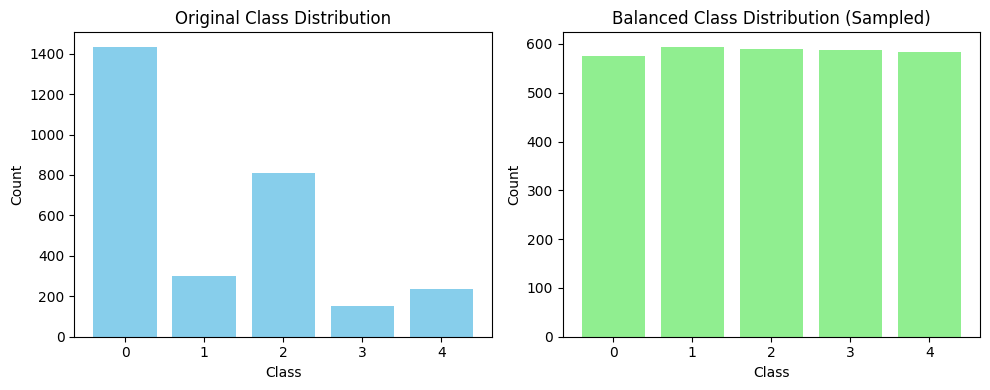

In [ ]:
# Enable inline plotting (for Colab/Jupyter)
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import WeightedRandomSampler

# Load your dataset (update path if needed)
train_df = pd.read_csv('/content/aptos_data/Aptos2018/train.csv')

# Ensure 'diagnosis' column exists
assert 'diagnosis' in train_df.columns, "Column 'diagnosis' not found in CSV"

# Original class distribution
orig_counts = train_df['diagnosis'].value_counts().sort_index()

# Compute class weights
class_weights = 1. / orig_counts
sample_weights = train_df['diagnosis'].map(class_weights).values

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

# Simulate sampling
balanced_indices = list(sampler)
balanced_labels = [train_df.iloc[i]['diagnosis'] for i in balanced_indices]
balanced_counts = Counter(balanced_labels)

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before balancing
axes[0].bar(orig_counts.index, orig_counts.values, color='skyblue')
axes[0].set_title("Original Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# After balancing
axes[1].bar(balanced_counts.keys(), balanced_counts.values(), color='lightgreen')
axes[1].set_title("Balanced Class Distribution (Sampled)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import timm

class HybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(HybridModel, self).__init__()

        # Load pretrained EfficientNet B0
        self.efficientnet = timm.create_model(
            'efficientnet_b0', pretrained=True, num_classes=0
        )

        # Load pretrained ResNet18
        self.resnet = timm.create_model(
            'resnet18', pretrained=True, num_classes=0
        )

        # Get output feature sizes
        self.efficientnet_out = self.efficientnet.num_features  # 1280
        self.resnet_out = self.resnet.num_features              # 512

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(self.efficientnet_out + self.resnet_out, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from both networks
        feat1 = self.efficientnet(x)  # Shape: (B, 1280)
        feat2 = self.resnet(x)        # Shape: (B, 512)

        # Concatenate features
        combined = torch.cat((feat1, feat2), dim=1)  # Shape: (B, 1792)

        # Classification
        out = self.fusion(combined)
        return out


In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridModel(num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # ---- TRAIN ----
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = train_correct / train_total

        # ---- VALIDATE ----
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/content/drive/MyDrive/hybrid_best.pth")
            print(f"✅ Best model saved with Val Acc: {best_acc:.4f}")

    print("\nTraining Complete!")
    print(f"Best Validation Accuracy: {best_acc:.4f}")


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)



Epoch 1/10
--------------------


Validation: 100%|██████████| 12/12 [01:32<00:00,  7.71s/it]


Train Loss: 1.1850 | Train Acc: 0.5123
Val Loss: 0.6761 | Val Acc: 0.7240
✅ Best model saved with Val Acc: 0.7240

Epoch 2/10
--------------------


Validation: 100%|██████████| 12/12 [01:33<00:00,  7.76s/it]


Train Loss: 0.7376 | Train Acc: 0.7102
Val Loss: 0.6158 | Val Acc: 0.7432
✅ Best model saved with Val Acc: 0.7432

Epoch 3/10
--------------------


Validation: 100%|██████████| 12/12 [01:36<00:00,  8.03s/it]


Train Loss: 0.5529 | Train Acc: 0.7840
Val Loss: 0.5391 | Val Acc: 0.8115
✅ Best model saved with Val Acc: 0.8115

Epoch 4/10
--------------------


Validation: 100%|██████████| 12/12 [01:34<00:00,  7.86s/it]


Train Loss: 0.4329 | Train Acc: 0.8392
Val Loss: 0.6227 | Val Acc: 0.7787

Epoch 5/10
--------------------


Validation: 100%|██████████| 12/12 [01:35<00:00,  7.92s/it]


Train Loss: 0.3377 | Train Acc: 0.8768
Val Loss: 0.6236 | Val Acc: 0.8115

Epoch 6/10
--------------------


Validation: 100%|██████████| 12/12 [01:32<00:00,  7.73s/it]


Train Loss: 0.2777 | Train Acc: 0.8959
Val Loss: 0.6298 | Val Acc: 0.8087

Epoch 7/10
--------------------


Validation: 100%|██████████| 12/12 [01:31<00:00,  7.64s/it]


Train Loss: 0.2274 | Train Acc: 0.9205
Val Loss: 0.6580 | Val Acc: 0.8224
✅ Best model saved with Val Acc: 0.8224

Epoch 8/10
--------------------


Validation: 100%|██████████| 12/12 [01:34<00:00,  7.87s/it]


Train Loss: 0.1962 | Train Acc: 0.9307
Val Loss: 0.7157 | Val Acc: 0.8142

Epoch 9/10
--------------------


Validation: 100%|██████████| 12/12 [01:32<00:00,  7.75s/it]


Train Loss: 0.1609 | Train Acc: 0.9444
Val Loss: 0.8000 | Val Acc: 0.8005

Epoch 10/10
--------------------


Validation: 100%|██████████| 12/12 [01:34<00:00,  7.88s/it]

Train Loss: 0.1388 | Train Acc: 0.9444
Val Loss: 0.7701 | Val Acc: 0.8115

Training Complete!
Best Validation Accuracy: 0.8224


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/hybrid_best_82.pth")


In [ ]:
# Load best model
model.load_state_dict(torch.load("/content/drive/MyDrive/hybrid_best_82.pth"))
model.eval()


HybridModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw

In [ ]:
import torch

# Load model
model = HybridModel(num_classes=5).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/hybrid_best_82.pth"))
model.eval()


HybridModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw

In [ ]:
# Replace with your actual DR class names
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]


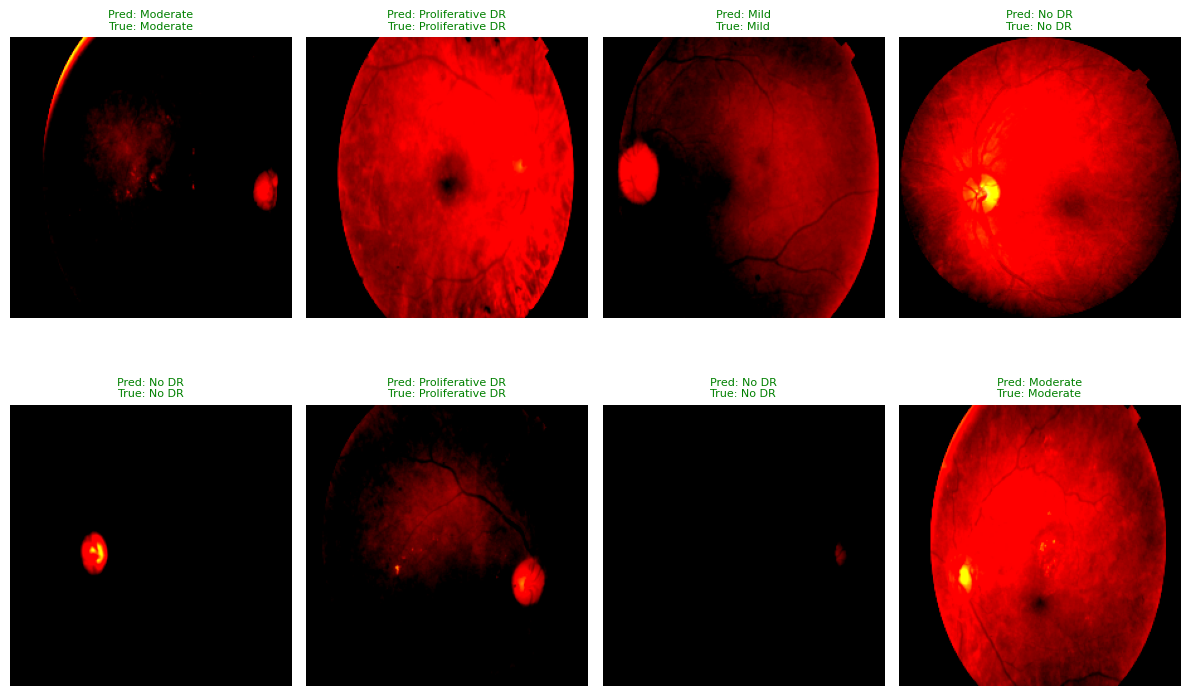

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a few random images from val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

images = images.to(device)
labels = labels.to(device)

# Predictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Plot
plt.figure(figsize=(12, 8))
for idx in range(8):  # show first 8 images
    ax = plt.subplot(2, 4, idx+1)
    imshow(images[idx].cpu())
    ax.set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}",
                 fontsize=8, color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()
plt.show()


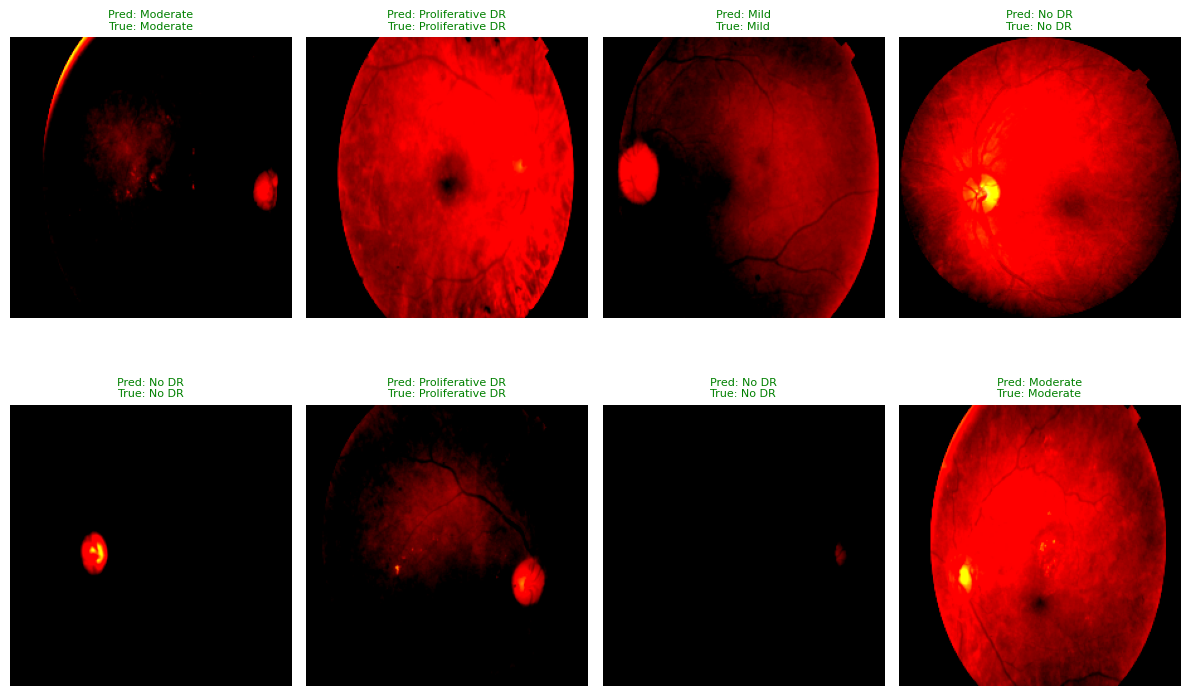

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def imshow(inp, title=None):
    """Display tensor as image."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

def show_random_predictions(model, loader, class_names, num_images=8):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, 8))

    while images_shown < num_images:
        # Pick a random batch
        images, labels = next(iter(loader))
        images, labels = images.to(device), labels.to(device)

        # Predictions
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        for idx in range(images.size(0)):
            if images_shown >= num_images:
                break
            ax = plt.subplot(2, 4, images_shown + 1)
            imshow(images[idx].cpu(),
                   title=f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")
            # Color title green if correct, red if wrong
            ax.title.set_color("green" if preds[idx] == labels[idx] else "red")
            images_shown += 1
    plt.tight_layout()
    plt.show()

# Show predictions from validation loader
show_random_predictions(model, val_loader, class_names)


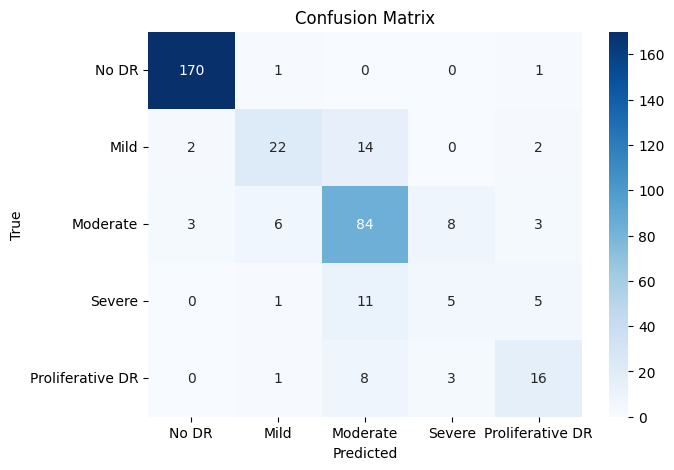

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot it
plot_confusion_matrix(model, val_loader, class_names)
